# Latent space analysis - right hemisphere

In [14]:
# Imports
import torch
import pandas as pd
import math
from vae import *
import datasets
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
side='R'
data_dir = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/'

## Loading of the model

In [3]:
root_dir ='/neurospin/dico/lguillon/midl_22/run_2/'
model = VAE((1, 12, 48, 48), 75, depth=3)
model.load_state_dict(torch.load(root_dir + 'checkpoint.pt'))

<All keys matched successfully>

## Analysis

### Loading of test data

In [21]:
# fetch data 
test_csv = '/neurospin/dico/data/deep_folding/current/test.csv'
test_list = pd.read_csv(test_csv, header=None, usecols=[0], names=['subjects'])
test_list['subjects'] = test_list['subjects'].astype('str')

# encode data
tmp = pd.read_pickle(os.path.join(data_dir, f"{side}skeleton.pkl")).T
tmp.index.astype('str')

tmp2 = pd.read_pickle(os.path.join(data_dir, f"benchmark_skeleton_right.pkl")).T
tmp2.index.astype('str')

tmp = tmp.merge(test_list[:math.floor(len(test_list)/2)], left_on = tmp.index, right_on='subjects', how='right')
tmp2 = tmp2.merge(test_list[math.ceil(len(test_list)/2):], left_on = tmp2.index, right_on='subjects', how='right')

filenames = list(test_list.subjects)
test_set = datasets.SkeletonDataset(dataframe=pd.concat([tmp, tmp2], ignore_index=True), filenames=filenames)

labels = np.array(['paracingular' for k in range(math.floor(len(tmp)))] \
         + ['SC' for k in range(math.ceil(len(tmp2)))])


corres_labels = pd.DataFrame(data={"subjects": filenames, "roi": labels})

In [23]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=False, num_workers=0)

dico_set_loaders = {'test': test_loader}

In [33]:
device = torch.device("cuda", index=0)
model = model.to(device)

class_weights = torch.FloatTensor([2, 7]).to(device)
#class_weights = torch.FloatTensor([2, 7])
distance = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# HCP -------- dataset_test_loader & benchmark
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=distance, kl_weight=2, n_latent=75,
                     depth=3, skeleton=True, root_dir=root_dir)

results = tester.test()

losses = {loader_name:[results[loader_name][k][0] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded = {loader_name:[results[loader_name][k][3] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [34]:
df_encoded = pd.DataFrame()

df_encoded['latent'] = encoded['test']

X = np.array(list(df_encoded['latent']))

In [35]:
X_embedded = TSNE(n_components=2).fit_transform(X)

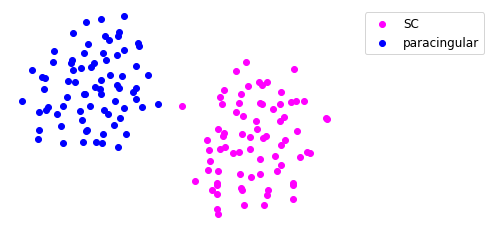

In [37]:
color_dict = {'paracingular': 'blue', 'SC': 'magenta'}
arr = X_embedded

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='SC':
        g_lab = 'SC'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)


plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()

In [40]:
# Kmeans
kmeans2d = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)
metrics.silhouette_score(X_embedded, kmeans2d)

0.65606064

In [43]:
# Kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)
metrics.silhouette_score(X, kmeans)

0.114223786